In [2]:
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

class StockOracle:
    """
    A class to simulate a stock's price using various stochastic processes.

    The simulation can be configured to model:
    - A pump-and-dump event with post-dump recovery.
    - A pure mean-reverting process (Ornstein-Uhlenbeck).
    - A trending process (random walk with drift).
    """
    def __init__(self, start_date, end_date, periods=365, x0=100, kappa=0.5, theta=100, sigma=0.5,
                 pump_start_percent=0.4, pump_end_percent=0.6, dump_end_percent=0.7,
                 post_dump_drift_strength=0.1, simulation_type="pump_and_dump", trend_drift=0.5):
        """
        Initializes the StockOracle with simulation parameters.

        Args:
            start_date (str): The start date for the simulation (e.g., '2023-01-01').
            end_date (str): The end date for the simulation (e.g., '2024-01-01').
            periods (int): The number of periods to simulate.
            x0 (float): The initial price of the stock.
            kappa (float): The rate of mean reversion.
            theta (float): The long-term mean of the process.
            sigma (float): The volatility of the process.
            pump_start_percent (float): The percentage of the period when the pump starts (0.0 to 1.0).
            pump_end_percent (float): The percentage of the period when the pump ends.
            dump_end_percent (float): The percentage of the period when the dump ends.
            post_dump_drift_strength (float): Strength of the negative drift after the dump.
            simulation_type (str): The type of simulation to run ("pump_and_dump", "mean_reverting", or "trend").
            trend_drift (float): The constant drift for the "trend" simulation.
        """
        self.start = start_date
        self.end = end_date
        self.periods = periods
        self.x0 = x0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.pump_start_percent = pump_start_percent
        self.pump_end_percent = pump_end_percent
        self.dump_end_percent = dump_end_percent
        self.post_dump_drift_strength = post_dump_drift_strength
        self.simulation_type = simulation_type
        self.trend_drift = trend_drift

        if self.simulation_type == "pump_and_dump":
            self.price_history = self._simulate_pump_dump_data()
        elif self.simulation_type == "mean_reverting":
            self.price_history = self._simulate_mean_reverting_data()
        elif self.simulation_type == "trend":
            self.price_history = self._simulate_trend_data()
        else:
            raise ValueError("Invalid simulation_type provided. Choose from 'pump_and_dump', 'mean_reverting', or 'trend'.")

    def _simulate_pump_dump_data(self):
        """
        Simulates the stock price data with pump-and-dump logic and post-dump behavior.
        """
        index = pd.date_range(start=self.start, end=self.end, periods=self.periods)

        # Determine the periods for each phase
        total_periods = len(index)
        pump_start_idx = int(total_periods * self.pump_start_percent)
        pump_end_idx = int(total_periods * self.pump_end_percent)
        dump_end_idx = int(total_periods * self.dump_end_percent)

        # Initialize price list with the starting price
        s = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / total_periods

        # Loop through each time period to simulate the price
        for t in range(1, total_periods):
            s_t_minus_1 = s[t - 1]

            # Base stochastic process (Ornstein-Uhlenbeck)
            drift = self.kappa * (self.theta - s_t_minus_1) * dt
            volatility = s_t_minus_1 * self.sigma * math.sqrt(dt) * random.gauss(0, 1)

            # --- Pump-and-Dump and Post-Dump Logic ---
            additional_drift = 0
            if pump_start_idx <= t < pump_end_idx:
                # Add a strong positive drift for the "pump" period
                additional_drift = 2.0 * dt * self.x0  # A strong positive constant drift
            elif pump_end_idx <= t < dump_end_idx:
                # Add a very strong negative drift for the "dump" period
                additional_drift = -5.0 * dt * self.x0 # An even stronger negative drift
            elif t >= dump_end_idx:
                # Gradual decrease towards initial price after the dump
                additional_drift = -self.post_dump_drift_strength * (s_t_minus_1 - self.x0) * dt

            # Calculate the new price
            s_t = (s_t_minus_1 + drift + volatility + additional_drift)
            s.append(max(0, s_t)) # Price cannot go below zero

        return pd.Series(s, index=index)

    def _simulate_mean_reverting_data(self):
        """
        Simulates the stock price using a pure mean-reverting (Ornstein-Uhlenbeck) process.
        """
        index = pd.date_range(start=self.start, end=self.end, periods=self.periods)
        s = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / len(index)
        for t in range(1, len(index)):
            s_t_minus_1 = s[t - 1]
            drift = self.kappa * (self.theta - s_t_minus_1) * dt
            volatility = s_t_minus_1 * self.sigma * math.sqrt(dt) * random.gauss(0, 1)
            s_t = (s_t_minus_1 + drift + volatility)
            s.append(max(0, s_t))
        return pd.Series(s, index=index)

    def _simulate_trend_data(self):
        """
        Simulates the stock price using a random walk with a constant drift.
        The trend is determined by the sign of the 'trend_drift' parameter.
        """
        index = pd.date_range(start=self.start, end=self.end, periods=self.periods)
        s = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / len(index)
        for t in range(1, len(index)):
            s_t_minus_1 = s[t - 1]
            # A constant drift is added to the random walk
            drift = self.trend_drift * dt * self.x0
            volatility = s_t_minus_1 * self.sigma * math.sqrt(dt) * random.gauss(0, 1)
            s_t = (s_t_minus_1 + drift + volatility)
            s.append(max(0, s_t))
        return pd.Series(s, index=index)

    def get_price_at_date(self, date):
        """
        Returns the simulated stock price for a given date.

        Args:
            date (str or pandas.Timestamp): The date to query.

        Returns:
            float: The simulated price, or None if the date is outside the range.
        """
        try:
            return self.price_history.loc[date]
        except KeyError:
            print(f"Date {date} is outside the simulation range.")
            return None

    def mean_reverting_price(self):
        """
        Returns the mean-reverting price of the stock.

        Returns:
            float: The long-term mean price (theta).
        """
        return self.theta

    def price_trend(self, days):
        """
        Determines the price trend (up or down) over a given number of days.

        Args:
            days (int): The number of days to look back for the trend.

        Returns:
            str: "Upward Trend", "Downward Trend", or "Insufficient Data".
        """
        if days >= len(self.price_history):
            return "Insufficient Data"

        start_price = self.price_history.iloc[-days-1]
        end_price = self.price_history.iloc[-1]

        if end_price > start_price:
            return "Upward Trend"
        elif end_price < start_price:
            return "Downward Trend"
        else:
            return "No Change"


In [4]:
import warnings

warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module="jupyter_client",
    message="datetime.datetime.utcnow() is deprecated"
)

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from typing import List, Dict, Set

class SyntheticMarketDataGenerator:
    def __init__(self,
                 num_records: int = 100_000,  # 100K trades
                 start_date: str = "2020-01-01",
                 end_date: str = "2020-12-31",  # 12 months
                 num_investors: int = 1500,     # Reduced for more density
                 num_manipulators: int = 40,   # Giant manipulator group of 20
                 symbols: List[str] = None):

        self.num_records = num_records
        self.start_date = datetime.strptime(start_date, "%Y-%m-%d")
        self.end_date = datetime.strptime(end_date, "%Y-%m-%d")
        self.num_investors = num_investors
        self.num_manipulators = num_manipulators
        self.symbols = symbols or ["FAKE"]

        self.oracle_pump_dump = StockOracle(
            start_date=start_date,
            end_date=end_date,
            periods=365,
            x0=100,
            simulation_type="pump_and_dump",
            pump_start_percent=0.1,
            pump_end_percent=0.45,
            dump_end_percent=0.55
        )

        # Trading hours: 9 AM to 3 PM (6 hours)
        self.market_open = timedelta(hours=9)
        self.market_close = timedelta(hours=15)

        # Generate investor IDs
        self.all_investors = [f"INV_{i:04d}" for i in range(1, num_investors + 1)]
        self.manipulators = self.all_investors[:num_manipulators]  # First 20 are manipulators
        self.manipulators = [f"M_{inv}" for inv in self.manipulators]
        self.normal_investors = self.all_investors[num_manipulators:]

        # Track used seconds to avoid collisions
        self.used_seconds = set()

    def _get_random_market_time(self, day: datetime) -> datetime:
        """Get random time during market hours"""
        random_seconds = random.randint(0, 6 * 3600 - 1)  # 6 hours in seconds
        market_time = day + self.market_open + timedelta(seconds=random_seconds)
        return market_time

    def _generate_manipulator_group_trade(self, timestamp: datetime) -> Dict:
        """Generate trade with 2-6 manipulators from the giant group in same second"""
        # Randomly select 2-6 manipulators to trade in this second
        group_size = random.randint(2, 6)
        active_manipulators = random.sample(self.manipulators, group_size)

        # Generate 1-3 trades among these manipulators in this second
        trades = []
        num_trades = random.randint(1, 3)

        for _ in range(num_trades):
            # 40% chance: trade between manipulators, 60%: with normal investors
            if random.random() < 0.4 and len(active_manipulators) >= 2:
                buyer_id, seller_id = random.sample(active_manipulators, 2)
            else:
                # Trade with normal investor
                if random.random() < 0.5:
                    buyer_id = random.choice(active_manipulators)
                    seller_id = random.choice(self.normal_investors)
                else:
                    seller_id = random.choice(active_manipulators)
                    buyer_id = random.choice(self.normal_investors)

            symbol = random.choice(self.symbols)
            price = self.oracle_pump_dump.get_price_at_date(timestamp.date().strftime("%Y-%m-%d"))
            quantity = random.choice([100, 200, 500, 1000])

            trades.append({
                'buyer_id': buyer_id,
                'seller_id': seller_id,
                'symbol': symbol,
                'price': price,
                'quantity': quantity,
                'date_time': timestamp
            })

        return trades

    def _generate_normal_trade(self, timestamp: datetime) -> Dict:
        """Generate a normal trade between random investors"""
        buyer_id = random.choice(self.normal_investors)
        seller_id = random.choice(self.normal_investors)

        while seller_id == buyer_id:
            seller_id = random.choice(self.normal_investors)

        symbol = random.choice(self.symbols)
        price = self.oracle_pump_dump.get_price_at_date(timestamp.date().strftime("%Y-%m-%d"))
        quantity = random.randint(1, 500)

        return {
            'buyer_id': buyer_id,
            'seller_id': seller_id,
            'symbol': symbol,
            'price': price,
            'quantity': quantity,
            'date_time': timestamp
        }

    def generate_data(self) -> pd.DataFrame:
        """Generate the synthetic market data"""
        data = []
        total_days = (self.end_date - self.start_date).days

        # First, ensure manipulators co-occur frequently
        print("Generating manipulator co-occurrence trades...")

        # Target: Each pair of manipulators should co-occur 100+ times
        # With 20 manipulators, there are 190 possible pairs
        # We'll create concentrated trading activity

        co_occurrence_target = 120  # Slightly above 100

        # Generate concentrated trading days
        for day_offset in range(total_days):
            current_day = self.start_date + timedelta(days=day_offset)

            # Skip weekends (optional)
            if current_day.weekday() >= 5:  # 5=Saturday, 6=Sunday
                continue

            # Generate high-frequency trading for manipulators on each trading day
            seconds_in_trading_day = 6 * 3600  # 6 hours

            for second_offset in range(0, seconds_in_trading_day, 10):  # Every 10 seconds
                if len(data) >= self.num_manipulators * co_occurrence_target * 3:  # manipulator trades
                    break

                timestamp = current_day + self.market_open + timedelta(seconds=second_offset)

                # Generate manipulator group trades
                trades = self._generate_manipulator_group_trade(timestamp)
                data.extend(trades)

        # Fill remaining with normal trades
        print("Generating normal trades...")
        remaining_records = self.num_records - len(data)

        i = 0
        while i < remaining_records:
            random_day = random.randint(0, total_days - 1)
            current_day = self.start_date + timedelta(days=random_day)

            # Only generate during trading hours
            if current_day.weekday() < 5:  # Weekdays only
                timestamp = self._get_random_market_time(current_day)
                trade = self._generate_normal_trade(timestamp)
                data.append(trade)
                i += 1

        df = pd.DataFrame(data)
        df = df.sort_values('date_time').reset_index(drop=True)

        return df

config = {
    "num_records": 100_000,      # 100K trades
    "start_date": "2020-01-01",
    "end_date": "2020-12-31",    # 12 months
    "num_investors": 1000,        # 1000 total investors
    "num_manipulators": 20,      # Giant group of 20 manipulators
    "symbols": ["FAKE"]
}

generator = SyntheticMarketDataGenerator(**config)
df = generator.generate_data()

# Save to CSV
output_file = "synthetic_market_data_100K.csv"
df.to_csv(output_file, index=False)

print(f"\n✅ Data generation complete!")
print(f"📊 Total records: {len(df):,}")
print(f"📅 Date range: {df['date_time'].min()} to {df['date_time'].max()}")
print(f"👥 Unique investors: {len(set(df['buyer_id'].tolist() + df['seller_id'].tolist()))}")
print(f"🎯 Manipulators: {len(generator.manipulators)}")
print(f"💾 Saved to: {output_file}")

Generating manipulator co-occurrence trades...
Generating normal trades...

✅ Data generation complete!
📊 Total records: 100,000
📅 Date range: 2020-01-01 09:00:00 to 2020-12-30 14:59:13
👥 Unique investors: 1000
🎯 Manipulators: 20
💾 Saved to: synthetic_market_data_100K_2months.csv


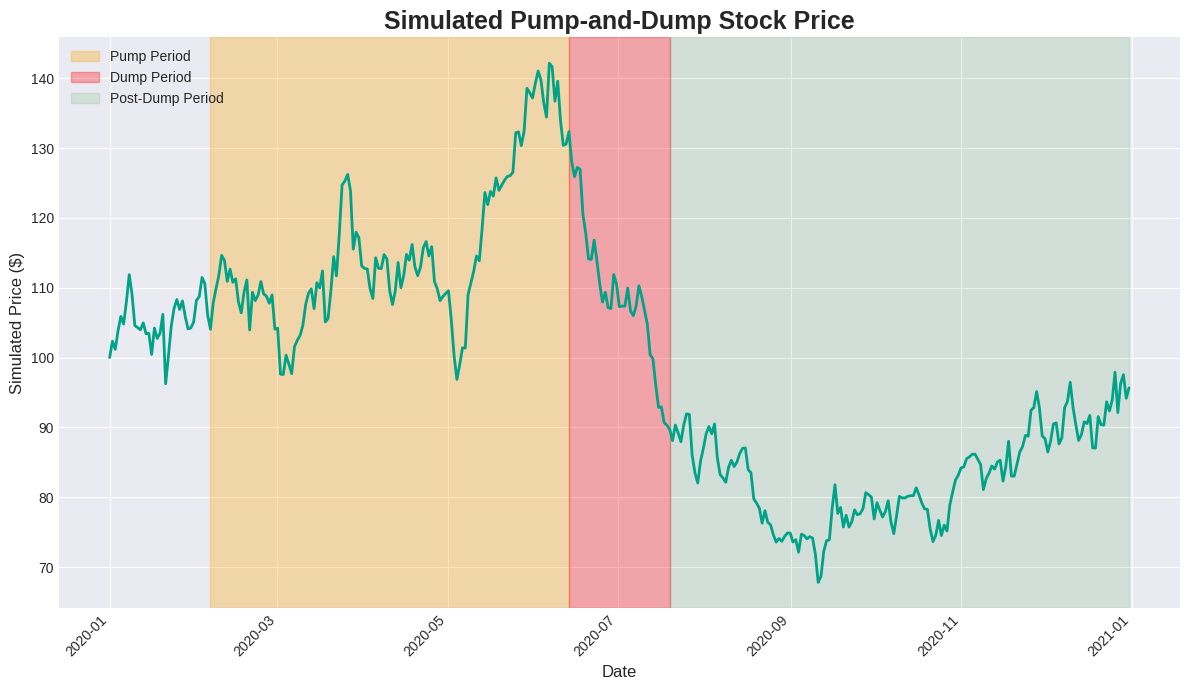

In [7]:
price_data_pump_dump = generator.oracle_pump_dump.price_history

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(price_data_pump_dump.index, price_data_pump_dump.values, color='#00A388', linewidth=2)

total_periods = len(price_data_pump_dump)
pump_start_idx = int(total_periods * generator.oracle_pump_dump.pump_start_percent)
pump_end_idx = int(total_periods * generator.oracle_pump_dump.pump_end_percent)
dump_end_idx = int(total_periods * generator.oracle_pump_dump.dump_end_percent)
ax.axvspan(price_data_pump_dump.index[pump_start_idx], price_data_pump_dump.index[pump_end_idx], color='orange', alpha=0.3, label='Pump Period')
ax.axvspan(price_data_pump_dump.index[pump_end_idx], price_data_pump_dump.index[dump_end_idx], color='red', alpha=0.3, label='Dump Period')
ax.axvspan(price_data_pump_dump.index[dump_end_idx], price_data_pump_dump.index[-1], color='green', alpha=0.1, label='Post-Dump Period')
ax.set_title('Simulated Pump-and-Dump Stock Price', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Simulated Price ($)', fontsize=12)
ax.legend(loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd

# Load CSV into DataFrame
df = pd.read_csv("synthetic_market_data_100K_2months.csv")

# Show first few rows
print(df.head())

# Show column names
print("\nColumns:", df.columns.tolist())

     buyer_id   seller_id symbol                                price  \
0  M_INV_0016  M_INV_0012   FAKE  2020-01-01    100.0\ndtype: float64   
1  M_INV_0017  M_INV_0016   FAKE  2020-01-01    100.0\ndtype: float64   
2  M_INV_0014    INV_0428   FAKE  2020-01-01    100.0\ndtype: float64   
3    INV_0521    INV_0337   FAKE  2020-01-01    100.0\ndtype: float64   
4    INV_0783    INV_0406   FAKE  2020-01-01    100.0\ndtype: float64   

   quantity            date_time  
0      1000  2020-01-01 09:00:00  
1       500  2020-01-01 09:00:00  
2       200  2020-01-01 09:00:00  
3       184  2020-01-01 09:00:03  
4       392  2020-01-01 09:00:07  

Columns: ['buyer_id', 'seller_id', 'symbol', 'price', 'quantity', 'date_time']


In [12]:
import warnings

warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module="jupyter_client",
    message=".*datetime.datetime.utcnow().*"
)

import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Load CSV
df = pd.read_csv("synthetic_market_data_100K_2months.csv")

# Convert to datetime and floor to minute
df["date_time"] = pd.to_datetime(df["date_time"])
df["minute"] = df["date_time"].dt.floor("min")

# ollect all investors (buyers + sellers)
df["buyer"] = df["buyer_id"]
df["seller"] = df["seller_id"]

# Melt into a single column of investors
investors = pd.melt(
    df,
    id_vars=["minute"],
    value_vars=["buyer", "seller"],
    value_name="investor_id"
)[["minute", "investor_id"]]

# Drop duplicates: each investor appears once per minute
investors = investors.drop_duplicates()

# Build basket (one-hot encoding: minute × investor)
baskets = (
    investors.assign(flag=1)
             .pivot_table(index="minute", columns="investor_id", values="flag", fill_value=0)
)

min_support = 150 / len(baskets)
frequent_itemsets = fpgrowth(baskets, min_support=min_support, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.25)
print(rules[['antecedents','consequents','support','confidence','lift']])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

     antecedents   consequents   support  confidence        lift
0   (M_INV_0006)  (M_INV_0015)  0.002599    0.504918   97.447536
1   (M_INV_0015)  (M_INV_0006)  0.002599    0.501629   97.447536
2   (M_INV_0014)  (M_INV_0006)  0.002734    0.532895  103.521355
3   (M_INV_0006)  (M_INV_0014)  0.002734    0.531148  103.521355
4   (M_INV_0006)  (M_INV_0005)  0.002633    0.511475  101.354241
5   (M_INV_0005)  (M_INV_0006)  0.002633    0.521739  101.354241
6   (M_INV_0003)  (M_INV_0005)  0.002599    0.496774   98.441040
7   (M_INV_0005)  (M_INV_0003)  0.002599    0.515050   98.441040
8   (M_INV_0014)  (M_INV_0016)  0.002582    0.503289  100.066783
9   (M_INV_0016)  (M_INV_0014)  0.002582    0.513423  100.066783
10  (M_INV_0006)  (M_INV_0016)  0.002549    0.495082   98.434921
11  (M_INV_0016)  (M_INV_0006)  0.002549    0.506711   98.434921
12  (M_INV_0016)  (M_INV_0003)  0.002582    0.513423   98.130006
13  (M_INV_0003)  (M_INV_0016)  0.002582    0.493548   98.130006
14  (M_INV_0010)  (M_INV_

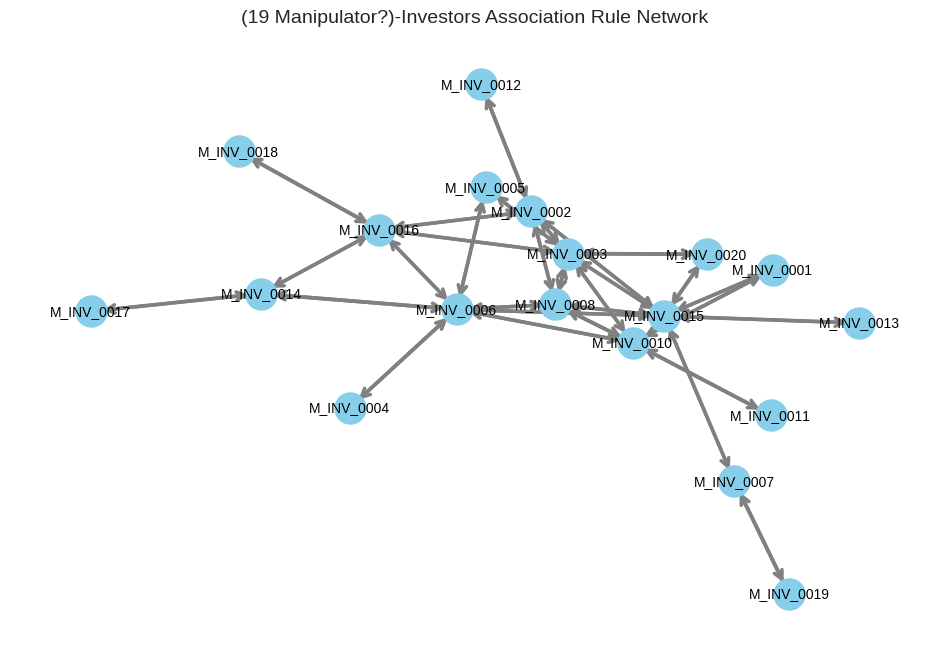

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# Suppose you already have your rules DataFrame
# from association_rules(...)
# rules[['antecedents','consequents','support','confidence','lift']]

# Create directed graph
G = nx.DiGraph()

# Add edges from rules
for _, row in rules.iterrows():
    # antecedents and consequents are frozensets -> convert to list
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(
                a, c,
                weight=row['confidence'],   # edge weight
                lift=row['lift']
            )

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3, seed=42)  # force-directed layout

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")

# Draw edges (thicker if higher confidence)
edges = nx.draw_networkx_edges(
    G, pos,
    arrowstyle="->", arrowsize=15,
    edge_color="gray",
    width=[d['weight']*5 for (_,_,d) in G.edges(data=True)]
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title(f"({G.number_of_nodes()} Manipulator?)-Investors Association Rule Network", fontsize=14)
plt.axis("off")
plt.savefig("investor_network.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
"""
To Open the graph in browser, pip install pyvis and run the following code:
"""

import networkx as nx
from pyvis.network import Network
from IPython.display import display, HTML

# Create directed graph from rules
G = nx.DiGraph()

for _, row in rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(
                a, c,
                weight=row['confidence'],
                title=f"support={row['support']:.3f}, conf={row['confidence']:.2f}, lift={row['lift']:.2f}"
            )

# Create PyVis network for notebook
net = Network(notebook=True, directed=True, height="750px", width="100%")

# Load the NetworkX graph
net.from_nx(G)

# Enable physics for nicer layout
net.toggle_physics(True)

# Display directly in Jupyter notebook
net.show("investor_rules_network_notebook.html")  # renders inline

import webbrowser
webbrowser.open("./investor_rules_network_notebook.html")


investor_rules_network_notebook.html


True